MainProcess
MainProcess


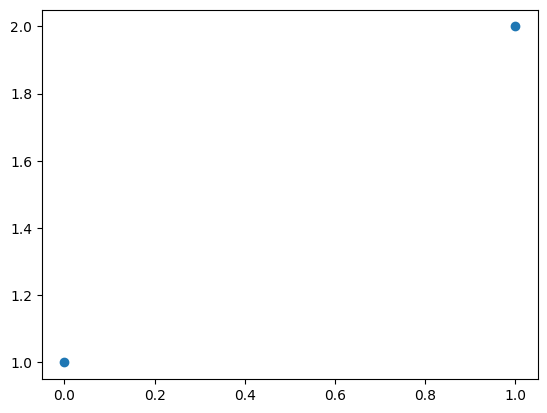

In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core')
sys.path.append('/flagellar/input/my-flg-library/')
import flg_support as fls
import importlib
import numpy as np
import flg_diagnostics
import flg_numerics
import matplotlib.pyplot as plt
import glob
import copy
import flg_preprocess
importlib.reload(fls);
fls.profiling=False
plt.scatter([0,1],[1,2])

In [2]:
files = glob.glob(fls.result_dir + '/many_abbr_full/Baseline_*0M*')
models = [fls.dill_load(f) for f in files]
models = sorted(models, key=lambda d:d.trained_model.seed)

In [3]:
todo = slice(None)
data = copy.deepcopy(models[0].inferred_test_data[todo])

In [4]:
# for m in models[0:1]:
#     m.trained_model.step1Labels.relative_confidence_threshold = 0.001
#     m.inferred_test_data = m.trained_model.infer(m.test_data)

In [5]:
models[0].trained_model.step1Labels.seed

0

In [6]:
#highest_false_score = []
#real_score = []
for i_type in [1]:#range(2):
    model = copy.deepcopy(models[0].untrained_model)
    model.step1Labels.relative_confidence_threshold = 0.001
    #model.step1Labels.n_epochs = 2
    #m.step2Motors.distance_threshold = 10.
    if i_type == 0:
        # baseline
        pass
    elif i_type==1:
        # blur
        model.step1Labels.preprocessor = flg_preprocess.Preprocessor2()
    model.run_in_parallel = False
    model.train(models[0].train_data, models[0].test_data)
    fls.dill_save(fls.temp_dir + 'model_' + str(i_type) + '.pickle', model)
    #model = fls.dill_load(fls.temp_dir + 'model_' + str(i_type) + '.pickle')
    inferred_data = model.infer(models[0].test_data[todo])
    for d in inferred_data:
        d.labels_unfiltered = d.labels_unfiltered2
    fls.mark_tf_pn(inferred_data, models[0].test_data[todo])
    this_highest_false_score = []
    this_real_score = []
    for i,r in zip(inferred_data, models[0].test_data[todo]):
        false_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==1.]
        if len(false_positives)>0:
            this_highest_false_score.append(np.max(false_positives['confidence']))
        else:
            this_highest_false_score.append(0)
        if len(r.labels)>0:
            true_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==0.]
            if len(true_positives)>0:
                this_real_score.append(np.max(true_positives['confidence']))
            else:
                this_real_score.append(0)
    highest_false_score.append(this_highest_false_score)
    real_score.append(this_real_score)


!!!


/opt/conda/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
(942, 942) (200, 200)
(942, 942)
100
(742, 742)
Clearing cupy
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
Processing tomogram aba2014-04-03-1 (1/1)
Processing 17 out of 17 slices (CONCENTRATIO

AssertionError: 

In [ ]:
%debug

In [ ]:
def f(v0,v1):
    return v1
    return np.max(np.stack((np.array(v0), np.array(v1))),axis=0)
f([1,2,3], [2,30,1])

In [ ]:
plt.scatter(highest_false_score[0], f(highest_false_score[0], highest_false_score[1]))
plt.xlabel('Highest false score baseline')
plt.ylabel('Highest false score new')
plt.grid(True)
plt.axline((0,0),slope=1)

In [ ]:
plt.scatter(real_score[0], f(real_score[0], real_score[1]))
plt.xlabel('True score baseline')
plt.ylabel('True score new')
plt.grid(True)
plt.axline((0,0),slope=1)

In [ ]:
# xx=np.argwhere(np.logical_and(np.array(highest_false_score[2])>0.6, np.array(highest_false_score[0])<0.01))
# xx

In [ ]:
# cur_id = 87
# for ii in range(len(models[0].test_data[todo])):
#     if len(models[0].test_data[todo][ii].labels)>0:        
#         if cur_id in xx:
#             print(models[0].test_data[todo][ii].name,ii,real_score[0][cur_id],real_score[2][cur_id])
#         cur_id+=1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# flatten the two arrays into one to get global bin edges
all_scores = np.concatenate([highest_false_score[0], highest_false_score[1]])
# choose number of bins (e.g. 30) or compute automatically
bins = np.histogram_bin_edges(all_scores, bins=30)

plt.figure(figsize=(8, 5))
plt.hist(highest_false_score[0], bins=bins, cumulative=True, alpha=0.5, label='Original')
plt.hist(highest_false_score[1], bins=bins, cumulative=True, alpha=0.5, label='New')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms of Highest False Scores - lower is better')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# flatten the two arrays into one to get global bin edges
all_scores = np.concatenate([real_score[0], real_score[1]])
# choose number of bins (e.g. 30) or compute automatically
bins = np.histogram_bin_edges(all_scores, bins=30)

plt.figure(figsize=(8, 5))
plt.hist(real_score[0], bins=bins, cumulative=True, alpha=0.5, label='Original')
plt.hist(real_score[1], bins=bins, cumulative=True, alpha=0.5, label='New')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms of True Scores - higher is better')
plt.legend()
plt.tight_layout()
plt.show()